In [ ]:
!pip install tensorflow

## Cargar imágenes

In [2]:
# conectar con google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import imghdr

data_path = "/content/drive/MyDrive/Colab Notebooks/tfg/fashion_images/fashion_images_converted"

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

n_images = 0
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_path).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            n_images += 1

print(f"Total not valid images: {n_images}")

/tmp/ipython-input-3-4119615236.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Total not valid images: 0


## Preprocesamiento

In [ ]:
import tensorflow as tf

IMG_SIZE = 64
BATCH_SIZE = 128

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest' # Add this for better resize quality
)

# Change the data type of the images to tf.float32 before normalization
dataset = dataset.map(lambda x: tf.cast(x, tf.float32))

# Normalizar entre [-1, 1] como recomienda DCGAN
dataset = dataset.map(lambda x: (x / 127.5) - 1)
dataset = dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 1843 files.


In [ ]:
import tensorflow as tf

IMG_SIZE = 64
BATCH_SIZE = 128

# Load dataset (no labels)
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest'
)

# Data augmentation function
def augment(image):
    # Random flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation (approx. 15 degrees)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random brightness & contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # Optional: random crop and resize back
    # image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 10, IMG_SIZE + 10)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    return image

def augment_batch(batch):
    return tf.map_fn(augment, batch)

dataset = dataset.map(augment_batch)  # Map the augment_batch function to the dataset
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 127.5 - 1.0)

# Shuffle and prefetch
dataset = dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 1843 files.


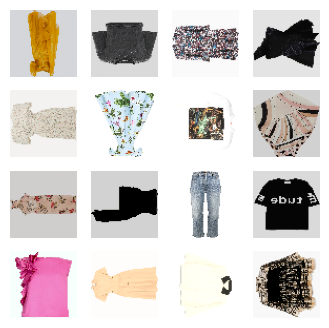

In [ ]:
import matplotlib.pyplot as plt

# Ejemplo para mostrar un batch de imágenes antes del entrenamiento
for images in dataset.take(1):
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        img = images[i].numpy()
        plt.imshow((img + 1) / 2)  # Si están en [-1, 1]
        plt.axis('off')
    plt.show()


## Generador y discriminador

In [ ]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()

    # Capa densa inicial
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((8, 8, 1024)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Bloques adicionales para mayor profundidad
    model.add(layers.Conv2DTranspose(1024, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))  # Extra layer
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))  # Extra layer
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Capa de salida con tanh para valores entre [-1, 1]
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


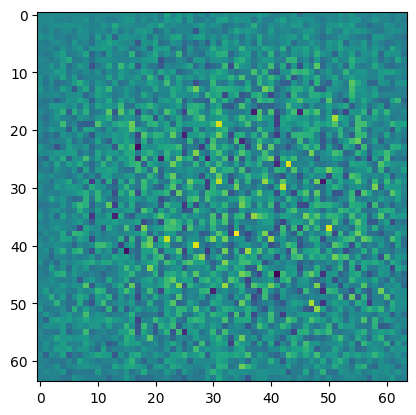

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='intermediate_layer'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00039809]], shape=(1, 1), dtype=float32)


## Pérdida

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) * 0.9 # 1 = real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 0 = fake
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # queremos engañar al disc

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Parámetros
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# Semilla fija para visualizar progreso
seed = tf.random.normal([num_examples_to_generate, noise_dim])


## Entrenamiento

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np # Import numpy
import time
from tqdm import tqdm

# Función para generar y guardar imágenes
def generate_and_save_images(model, epoch, test_input, output_dir="generated_images"):
    os.makedirs(output_dir, exist_ok=True)

    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i] + 1) / 2.0  # Reescala si está en [-1, 1]
        # Ensure the image data is a valid numeric type before displaying
        img_data = img.numpy().squeeze()
        if img_data.dtype == 'object':
            # If dtype is object, likely an empty image, skip or handle appropriately
            print(f"Warning: Image {i} has dtype 'object' and cannot be displayed.")
            continue  # Skip this image
        # Convert to a suitable dtype if necessary
        # img_data = img_data.astype(np.float32)
        plt.imshow(img_data)
        plt.axis('off')

    save_path = os.path.join(output_dir, f'image_at_epoch_{epoch:03d}.png')
    plt.savefig(save_path)
    plt.close()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        # Inicializamos la barra de progreso para cada epoch
        with tqdm(total=len(dataset), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
            for image_batch in dataset:
                gen_loss, disc_loss = train_step(image_batch)

                # Actualizar la barra de progreso
                pbar.set_postfix(Gen_Loss=gen_loss, Disc_Loss=disc_loss)
                pbar.update(1)  # Avanzamos la barra de progreso

        # Generar imágenes después de cada epoch
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}, Time: {time.time()-start:.2f}s')

    # Imagen final
    generate_and_save_images(generator, epochs, seed)


In [ ]:
train(dataset, epochs=100)

Epoch 1/100: 100%|██████████| 15/15 [00:46<00:00,  3.11s/batch, Disc_Loss=tf.Tensor(1.3898854, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.61698973, shape=(), dtype=float32)]


Epoch 1, Gen Loss: 0.6170, Disc Loss: 1.3899, Time: 48.04s


Epoch 2/100: 100%|██████████| 15/15 [00:23<00:00,  1.54s/batch, Disc_Loss=tf.Tensor(1.2088892, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.9149375, shape=(), dtype=float32)]


Epoch 2, Gen Loss: 0.9149, Disc Loss: 1.2089, Time: 23.40s


Epoch 3/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4229302, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7593198, shape=(), dtype=float32)]


Epoch 3, Gen Loss: 0.7593, Disc Loss: 1.4229, Time: 41.21s


Epoch 4/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4737015, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.69162107, shape=(), dtype=float32)]


Epoch 4, Gen Loss: 0.6916, Disc Loss: 1.4737, Time: 41.22s


Epoch 5/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4457622, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.64313436, shape=(), dtype=float32)]


Epoch 5, Gen Loss: 0.6431, Disc Loss: 1.4458, Time: 41.33s


Epoch 6/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2770225, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6785113, shape=(), dtype=float32)]


Epoch 6, Gen Loss: 0.6785, Disc Loss: 1.2770, Time: 41.21s


Epoch 7/100: 100%|██████████| 15/15 [00:23<00:00,  1.54s/batch, Disc_Loss=tf.Tensor(1.4138533, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.70362663, shape=(), dtype=float32)]


Epoch 7, Gen Loss: 0.7036, Disc Loss: 1.4139, Time: 23.42s


Epoch 8/100: 100%|██████████| 15/15 [00:21<00:00,  1.43s/batch, Disc_Loss=tf.Tensor(1.418057, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.718974, shape=(), dtype=float32)]


Epoch 8, Gen Loss: 0.7190, Disc Loss: 1.4181, Time: 22.07s


Epoch 9/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3953447, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7336748, shape=(), dtype=float32)]


Epoch 9, Gen Loss: 0.7337, Disc Loss: 1.3953, Time: 41.28s


Epoch 10/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3621738, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7183225, shape=(), dtype=float32)]


Epoch 10, Gen Loss: 0.7183, Disc Loss: 1.3622, Time: 41.20s


Epoch 11/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.340734, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7159287, shape=(), dtype=float32)]


Epoch 11, Gen Loss: 0.7159, Disc Loss: 1.3407, Time: 41.23s


Epoch 12/100: 100%|██████████| 15/15 [00:22<00:00,  1.52s/batch, Disc_Loss=tf.Tensor(1.3605037, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7064806, shape=(), dtype=float32)]


Epoch 12, Gen Loss: 0.7065, Disc Loss: 1.3605, Time: 22.99s


Epoch 13/100: 100%|██████████| 15/15 [00:22<00:00,  1.47s/batch, Disc_Loss=tf.Tensor(1.3546507, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7000636, shape=(), dtype=float32)]


Epoch 13, Gen Loss: 0.7001, Disc Loss: 1.3547, Time: 22.45s


Epoch 14/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3796697, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7027014, shape=(), dtype=float32)]


Epoch 14, Gen Loss: 0.7027, Disc Loss: 1.3797, Time: 41.21s


Epoch 15/100: 100%|██████████| 15/15 [00:22<00:00,  1.48s/batch, Disc_Loss=tf.Tensor(1.317491, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7995026, shape=(), dtype=float32)]


Epoch 15, Gen Loss: 0.7995, Disc Loss: 1.3175, Time: 41.72s


Epoch 16/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3998511, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7774104, shape=(), dtype=float32)]


Epoch 16, Gen Loss: 0.7774, Disc Loss: 1.3999, Time: 41.61s


Epoch 17/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2739321, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.70794165, shape=(), dtype=float32)]


Epoch 17, Gen Loss: 0.7079, Disc Loss: 1.2739, Time: 41.28s


Epoch 18/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3373811, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.74351275, shape=(), dtype=float32)]


Epoch 18, Gen Loss: 0.7435, Disc Loss: 1.3374, Time: 41.23s


Epoch 19/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3459544, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6959608, shape=(), dtype=float32)]


Epoch 19, Gen Loss: 0.6960, Disc Loss: 1.3460, Time: 41.22s


Epoch 20/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3591975, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7691628, shape=(), dtype=float32)]


Epoch 20, Gen Loss: 0.7692, Disc Loss: 1.3592, Time: 41.21s


Epoch 21/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4386773, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6396613, shape=(), dtype=float32)]


Epoch 21, Gen Loss: 0.6397, Disc Loss: 1.4387, Time: 41.29s


Epoch 22/100: 100%|██████████| 15/15 [00:22<00:00,  1.49s/batch, Disc_Loss=tf.Tensor(1.4433446, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7072488, shape=(), dtype=float32)]


Epoch 22, Gen Loss: 0.7072, Disc Loss: 1.4433, Time: 22.59s


Epoch 23/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3670716, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6901821, shape=(), dtype=float32)]


Epoch 23, Gen Loss: 0.6902, Disc Loss: 1.3671, Time: 41.19s


Epoch 24/100: 100%|██████████| 15/15 [00:23<00:00,  1.54s/batch, Disc_Loss=tf.Tensor(1.3307437, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7269602, shape=(), dtype=float32)]


Epoch 24, Gen Loss: 0.7270, Disc Loss: 1.3307, Time: 23.27s


Epoch 25/100: 100%|██████████| 15/15 [00:23<00:00,  1.55s/batch, Disc_Loss=tf.Tensor(1.4568468, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.5819924, shape=(), dtype=float32)]


Epoch 25, Gen Loss: 0.5820, Disc Loss: 1.4568, Time: 23.49s


Epoch 26/100: 100%|██████████| 15/15 [00:22<00:00,  1.50s/batch, Disc_Loss=tf.Tensor(1.486672, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6359561, shape=(), dtype=float32)]


Epoch 26, Gen Loss: 0.6360, Disc Loss: 1.4867, Time: 22.81s


Epoch 27/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3488994, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7152413, shape=(), dtype=float32)]


Epoch 27, Gen Loss: 0.7152, Disc Loss: 1.3489, Time: 41.65s


Epoch 28/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3845134, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.66384375, shape=(), dtype=float32)]


Epoch 28, Gen Loss: 0.6638, Disc Loss: 1.3845, Time: 41.19s


Epoch 29/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4588438, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6542597, shape=(), dtype=float32)]


Epoch 29, Gen Loss: 0.6543, Disc Loss: 1.4588, Time: 41.23s


Epoch 30/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3710237, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.69854057, shape=(), dtype=float32)]


Epoch 30, Gen Loss: 0.6985, Disc Loss: 1.3710, Time: 48.63s


Epoch 31/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3341217, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.74219656, shape=(), dtype=float32)]


Epoch 31, Gen Loss: 0.7422, Disc Loss: 1.3341, Time: 41.22s


Epoch 32/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.430408, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.64346075, shape=(), dtype=float32)]


Epoch 32, Gen Loss: 0.6435, Disc Loss: 1.4304, Time: 41.28s


Epoch 33/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3239977, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7336143, shape=(), dtype=float32)]


Epoch 33, Gen Loss: 0.7336, Disc Loss: 1.3240, Time: 41.21s


Epoch 34/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3234031, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.79103446, shape=(), dtype=float32)]


Epoch 34, Gen Loss: 0.7910, Disc Loss: 1.3234, Time: 41.21s


Epoch 35/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2950253, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7315561, shape=(), dtype=float32)]


Epoch 35, Gen Loss: 0.7316, Disc Loss: 1.2950, Time: 41.22s


Epoch 36/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4260149, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6345378, shape=(), dtype=float32)]


Epoch 36, Gen Loss: 0.6345, Disc Loss: 1.4260, Time: 41.21s


Epoch 37/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3524666, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.75682265, shape=(), dtype=float32)]


Epoch 37, Gen Loss: 0.7568, Disc Loss: 1.3525, Time: 41.32s


Epoch 38/100: 100%|██████████| 15/15 [00:21<00:00,  1.45s/batch, Disc_Loss=tf.Tensor(1.3283987, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.73522466, shape=(), dtype=float32)]


Epoch 38, Gen Loss: 0.7352, Disc Loss: 1.3284, Time: 21.98s


Epoch 39/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3259206, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.78690785, shape=(), dtype=float32)]


Epoch 39, Gen Loss: 0.7869, Disc Loss: 1.3259, Time: 42.06s


Epoch 40/100: 100%|██████████| 15/15 [00:21<00:00,  1.45s/batch, Disc_Loss=tf.Tensor(1.275059, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7277016, shape=(), dtype=float32)]


Epoch 40, Gen Loss: 0.7277, Disc Loss: 1.2751, Time: 22.03s


Epoch 41/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4216611, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6962675, shape=(), dtype=float32)]


Epoch 41, Gen Loss: 0.6963, Disc Loss: 1.4217, Time: 41.31s


Epoch 42/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3114448, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.9008484, shape=(), dtype=float32)]


Epoch 42, Gen Loss: 0.9008, Disc Loss: 1.3114, Time: 41.24s


Epoch 43/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.288828, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.9212605, shape=(), dtype=float32)]


Epoch 43, Gen Loss: 0.9213, Disc Loss: 1.2888, Time: 41.20s


Epoch 44/100: 100%|██████████| 15/15 [00:23<00:00,  1.56s/batch, Disc_Loss=tf.Tensor(1.2598658, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.8044876, shape=(), dtype=float32)]


Epoch 44, Gen Loss: 0.8045, Disc Loss: 1.2599, Time: 23.56s


Epoch 45/100: 100%|██████████| 15/15 [00:22<00:00,  1.50s/batch, Disc_Loss=tf.Tensor(1.3203268, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.74791014, shape=(), dtype=float32)]


Epoch 45, Gen Loss: 0.7479, Disc Loss: 1.3203, Time: 35.90s


Epoch 46/100: 100%|██████████| 15/15 [00:22<00:00,  1.48s/batch, Disc_Loss=tf.Tensor(1.1684474, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.9295979, shape=(), dtype=float32)]


Epoch 46, Gen Loss: 0.9296, Disc Loss: 1.1684, Time: 22.43s


Epoch 47/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3940605, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6989492, shape=(), dtype=float32)]


Epoch 47, Gen Loss: 0.6989, Disc Loss: 1.3941, Time: 41.31s


Epoch 48/100: 100%|██████████| 15/15 [00:23<00:00,  1.53s/batch, Disc_Loss=tf.Tensor(1.2897954, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.862741, shape=(), dtype=float32)]


Epoch 48, Gen Loss: 0.8627, Disc Loss: 1.2898, Time: 23.41s


Epoch 49/100: 100%|██████████| 15/15 [00:24<00:00,  1.61s/batch, Disc_Loss=tf.Tensor(1.3417199, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6700201, shape=(), dtype=float32)]


Epoch 49, Gen Loss: 0.6700, Disc Loss: 1.3417, Time: 24.36s


Epoch 50/100: 100%|██████████| 15/15 [00:23<00:00,  1.54s/batch, Disc_Loss=tf.Tensor(1.3238854, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7246927, shape=(), dtype=float32)]


Epoch 50, Gen Loss: 0.7247, Disc Loss: 1.3239, Time: 23.36s


Epoch 51/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2903258, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.77523047, shape=(), dtype=float32)]


Epoch 51, Gen Loss: 0.7752, Disc Loss: 1.2903, Time: 41.22s


Epoch 52/100: 100%|██████████| 15/15 [00:23<00:00,  1.58s/batch, Disc_Loss=tf.Tensor(1.2449453, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7376574, shape=(), dtype=float32)]


Epoch 52, Gen Loss: 0.7377, Disc Loss: 1.2449, Time: 23.89s


Epoch 53/100: 100%|██████████| 15/15 [00:22<00:00,  1.52s/batch, Disc_Loss=tf.Tensor(1.2099802, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.90908384, shape=(), dtype=float32)]


Epoch 53, Gen Loss: 0.9091, Disc Loss: 1.2100, Time: 23.12s


Epoch 54/100: 100%|██████████| 15/15 [00:22<00:00,  1.48s/batch, Disc_Loss=tf.Tensor(1.3412032, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7184285, shape=(), dtype=float32)]


Epoch 54, Gen Loss: 0.7184, Disc Loss: 1.3412, Time: 22.50s


Epoch 55/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3402959, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6181383, shape=(), dtype=float32)]


Epoch 55, Gen Loss: 0.6181, Disc Loss: 1.3403, Time: 41.29s


Epoch 56/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2875139, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.68939805, shape=(), dtype=float32)]


Epoch 56, Gen Loss: 0.6894, Disc Loss: 1.2875, Time: 42.00s


Epoch 57/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.224431, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.74589777, shape=(), dtype=float32)]


Epoch 57, Gen Loss: 0.7459, Disc Loss: 1.2244, Time: 41.21s


Epoch 58/100: 100%|██████████| 15/15 [00:23<00:00,  1.54s/batch, Disc_Loss=tf.Tensor(1.3159714, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7145983, shape=(), dtype=float32)]


Epoch 58, Gen Loss: 0.7146, Disc Loss: 1.3160, Time: 23.40s


Epoch 59/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3458095, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7151824, shape=(), dtype=float32)]


Epoch 59, Gen Loss: 0.7152, Disc Loss: 1.3458, Time: 41.22s


Epoch 60/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3184645, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6549229, shape=(), dtype=float32)]


Epoch 60, Gen Loss: 0.6549, Disc Loss: 1.3185, Time: 51.99s


Epoch 61/100: 100%|██████████| 15/15 [00:23<00:00,  1.56s/batch, Disc_Loss=tf.Tensor(1.3346558, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.72187644, shape=(), dtype=float32)]


Epoch 61, Gen Loss: 0.7219, Disc Loss: 1.3347, Time: 23.67s


Epoch 62/100: 100%|██████████| 15/15 [00:23<00:00,  1.55s/batch, Disc_Loss=tf.Tensor(1.3699968, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.71402335, shape=(), dtype=float32)]


Epoch 62, Gen Loss: 0.7140, Disc Loss: 1.3700, Time: 23.47s


Epoch 63/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3737019, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7089942, shape=(), dtype=float32)]


Epoch 63, Gen Loss: 0.7090, Disc Loss: 1.3737, Time: 41.22s


Epoch 64/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3493558, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7313091, shape=(), dtype=float32)]


Epoch 64, Gen Loss: 0.7313, Disc Loss: 1.3494, Time: 41.23s


Epoch 65/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3360767, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.66846114, shape=(), dtype=float32)]


Epoch 65, Gen Loss: 0.6685, Disc Loss: 1.3361, Time: 41.21s


Epoch 66/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3300858, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7156504, shape=(), dtype=float32)]


Epoch 66, Gen Loss: 0.7157, Disc Loss: 1.3301, Time: 41.32s


Epoch 67/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3393975, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.723325, shape=(), dtype=float32)]


Epoch 67, Gen Loss: 0.7233, Disc Loss: 1.3394, Time: 41.21s


Epoch 68/100: 100%|██████████| 15/15 [00:22<00:00,  1.53s/batch, Disc_Loss=tf.Tensor(1.3307196, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7690508, shape=(), dtype=float32)]


Epoch 68, Gen Loss: 0.7691, Disc Loss: 1.3307, Time: 23.13s


Epoch 69/100: 100%|██████████| 15/15 [00:21<00:00,  1.44s/batch, Disc_Loss=tf.Tensor(1.313615, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6950553, shape=(), dtype=float32)]


Epoch 69, Gen Loss: 0.6951, Disc Loss: 1.3136, Time: 21.82s


Epoch 70/100: 100%|██████████| 15/15 [00:23<00:00,  1.54s/batch, Disc_Loss=tf.Tensor(1.3116807, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.72610056, shape=(), dtype=float32)]


Epoch 70, Gen Loss: 0.7261, Disc Loss: 1.3117, Time: 23.27s


Epoch 71/100: 100%|██████████| 15/15 [00:23<00:00,  1.55s/batch, Disc_Loss=tf.Tensor(1.3191156, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6141423, shape=(), dtype=float32)]


Epoch 71, Gen Loss: 0.6141, Disc Loss: 1.3191, Time: 23.52s


Epoch 72/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3199221, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7120032, shape=(), dtype=float32)]


Epoch 72, Gen Loss: 0.7120, Disc Loss: 1.3199, Time: 41.22s


Epoch 73/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2920051, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.72979325, shape=(), dtype=float32)]


Epoch 73, Gen Loss: 0.7298, Disc Loss: 1.2920, Time: 41.21s


Epoch 74/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3300538, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.72160083, shape=(), dtype=float32)]


Epoch 74, Gen Loss: 0.7216, Disc Loss: 1.3301, Time: 41.28s


Epoch 75/100: 100%|██████████| 15/15 [00:22<00:00,  1.51s/batch, Disc_Loss=tf.Tensor(1.3298392, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7083185, shape=(), dtype=float32)]


Epoch 75, Gen Loss: 0.7083, Disc Loss: 1.3298, Time: 41.37s


Epoch 76/100: 100%|██████████| 15/15 [00:21<00:00,  1.45s/batch, Disc_Loss=tf.Tensor(1.3276012, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7044836, shape=(), dtype=float32)]


Epoch 76, Gen Loss: 0.7045, Disc Loss: 1.3276, Time: 22.97s


Epoch 77/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3093626, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.8047247, shape=(), dtype=float32)]


Epoch 77, Gen Loss: 0.8047, Disc Loss: 1.3094, Time: 41.20s


Epoch 78/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3781524, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.67275244, shape=(), dtype=float32)]


Epoch 78, Gen Loss: 0.6728, Disc Loss: 1.3782, Time: 41.20s


Epoch 79/100: 100%|██████████| 15/15 [00:23<00:00,  1.55s/batch, Disc_Loss=tf.Tensor(1.303709, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.8466783, shape=(), dtype=float32)]


Epoch 79, Gen Loss: 0.8467, Disc Loss: 1.3037, Time: 23.41s


Epoch 80/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3595712, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7029897, shape=(), dtype=float32)]


Epoch 80, Gen Loss: 0.7030, Disc Loss: 1.3596, Time: 41.21s


Epoch 81/100: 100%|██████████| 15/15 [00:22<00:00,  1.51s/batch, Disc_Loss=tf.Tensor(1.3000531, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.77470154, shape=(), dtype=float32)]


Epoch 81, Gen Loss: 0.7747, Disc Loss: 1.3001, Time: 22.93s


Epoch 82/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.310092, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.78242344, shape=(), dtype=float32)]


Epoch 82, Gen Loss: 0.7824, Disc Loss: 1.3101, Time: 41.21s


Epoch 83/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3574846, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7753215, shape=(), dtype=float32)]


Epoch 83, Gen Loss: 0.7753, Disc Loss: 1.3575, Time: 41.22s


Epoch 84/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3087304, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7214663, shape=(), dtype=float32)]


Epoch 84, Gen Loss: 0.7215, Disc Loss: 1.3087, Time: 41.28s


Epoch 85/100: 100%|██████████| 15/15 [00:22<00:00,  1.48s/batch, Disc_Loss=tf.Tensor(1.3382161, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7144049, shape=(), dtype=float32)]


Epoch 85, Gen Loss: 0.7144, Disc Loss: 1.3382, Time: 22.44s


Epoch 86/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3352351, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.72272205, shape=(), dtype=float32)]


Epoch 86, Gen Loss: 0.7227, Disc Loss: 1.3352, Time: 41.22s


Epoch 87/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2791345, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.80383754, shape=(), dtype=float32)]


Epoch 87, Gen Loss: 0.8038, Disc Loss: 1.2791, Time: 41.33s


Epoch 88/100: 100%|██████████| 15/15 [00:21<00:00,  1.46s/batch, Disc_Loss=tf.Tensor(1.3145282, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.8374795, shape=(), dtype=float32)]


Epoch 88, Gen Loss: 0.8375, Disc Loss: 1.3145, Time: 22.08s


Epoch 89/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2505271, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.73167795, shape=(), dtype=float32)]


Epoch 89, Gen Loss: 0.7317, Disc Loss: 1.2505, Time: 41.31s


Epoch 90/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2555192, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.832563, shape=(), dtype=float32)]


Epoch 90, Gen Loss: 0.8326, Disc Loss: 1.2555, Time: 45.45s


Epoch 91/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3535874, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6685312, shape=(), dtype=float32)]


Epoch 91, Gen Loss: 0.6685, Disc Loss: 1.3536, Time: 41.21s


Epoch 92/100: 100%|██████████| 15/15 [00:23<00:00,  1.53s/batch, Disc_Loss=tf.Tensor(1.3245239, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7480871, shape=(), dtype=float32)]


Epoch 92, Gen Loss: 0.7481, Disc Loss: 1.3245, Time: 23.26s


Epoch 93/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3420541, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6892802, shape=(), dtype=float32)]


Epoch 93, Gen Loss: 0.6893, Disc Loss: 1.3421, Time: 41.21s


Epoch 94/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.3309062, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.79335976, shape=(), dtype=float32)]


Epoch 94, Gen Loss: 0.7934, Disc Loss: 1.3309, Time: 41.30s


Epoch 95/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2830865, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6936779, shape=(), dtype=float32)]


Epoch 95, Gen Loss: 0.6937, Disc Loss: 1.2831, Time: 41.21s


Epoch 96/100: 100%|██████████| 15/15 [00:21<00:00,  1.45s/batch, Disc_Loss=tf.Tensor(1.302359, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7370094, shape=(), dtype=float32)]


Epoch 96, Gen Loss: 0.7370, Disc Loss: 1.3024, Time: 22.05s


Epoch 97/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2880957, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.85765904, shape=(), dtype=float32)]


Epoch 97, Gen Loss: 0.8577, Disc Loss: 1.2881, Time: 41.21s


Epoch 98/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2969921, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.71812826, shape=(), dtype=float32)]


Epoch 98, Gen Loss: 0.7181, Disc Loss: 1.2970, Time: 41.22s


Epoch 99/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.4092348, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.6616516, shape=(), dtype=float32)]


Epoch 99, Gen Loss: 0.6617, Disc Loss: 1.4092, Time: 41.21s


Epoch 100/100: 100%|██████████| 15/15 [00:40<00:00,  2.73s/batch, Disc_Loss=tf.Tensor(1.2974646, shape=(), dtype=float32), Gen_Loss=tf.Tensor(0.7681141, shape=(), dtype=float32)]


Epoch 100, Gen Loss: 0.7681, Disc Loss: 1.2975, Time: 41.20s


## Guardar imágenes

In [ ]:
import os

destination_folder = '/content/drive/MyDrive/Colab Notebooks/tfg/generated_images_model_1_v3'
os.makedirs(destination_folder, exist_ok=True)

import shutil

source_folder = 'generated_images'  # carpeta local en Colab
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

# print(f"Se copiaron {len(png_files)} archivos .png a {destination_folder}")


## Mostrar imágenes

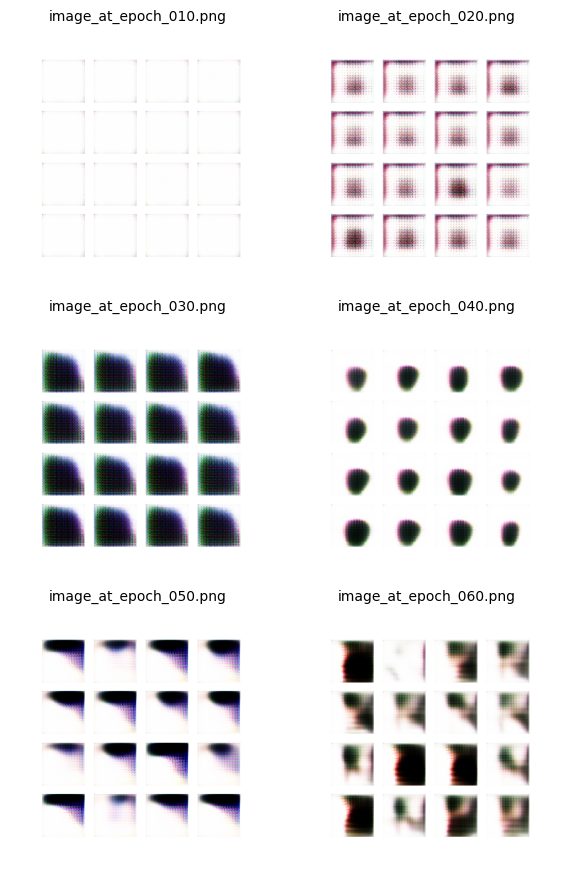

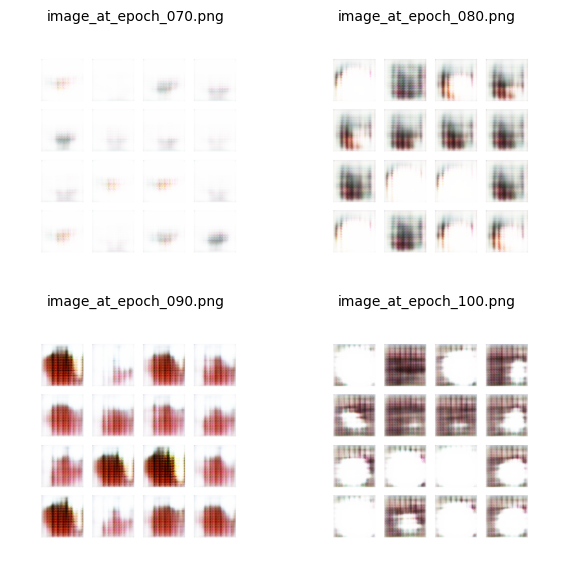

In [3]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Extraer número desde el nombre del archivo
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else -1

# Mostrar imágenes en una cuadrícula configurable
def show_images_grid(images, num_rows, num_cols, title=""):
    plt.figure(figsize=(num_cols * 3, num_rows * 3))
    for i, file_name in enumerate(images):
        img = mpimg.imread(file_name)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(file_name), fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Directorio de imágenes
dir = '/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1_v3'
modulo = 10  # Cambia esto si solo quieres cada n imagen

# Filtrar y ordenar
png_files = [f for f in os.listdir(dir) if f.endswith('.png')]
png_files = [f for f in png_files if extract_number(f) % modulo == 0]
png_files = sorted(png_files, key=extract_number)

# Cargar rutas completas
png_paths = [os.path.join(dir, f) for f in png_files]

# Mostrar primeras 6 (en cuadrícula 2x3)
show_images_grid(png_paths[:6], 3, 2)

# Mostrar siguientes 4 (en cuadrícula 2x2)
show_images_grid(png_paths[6:10], 2, 2)

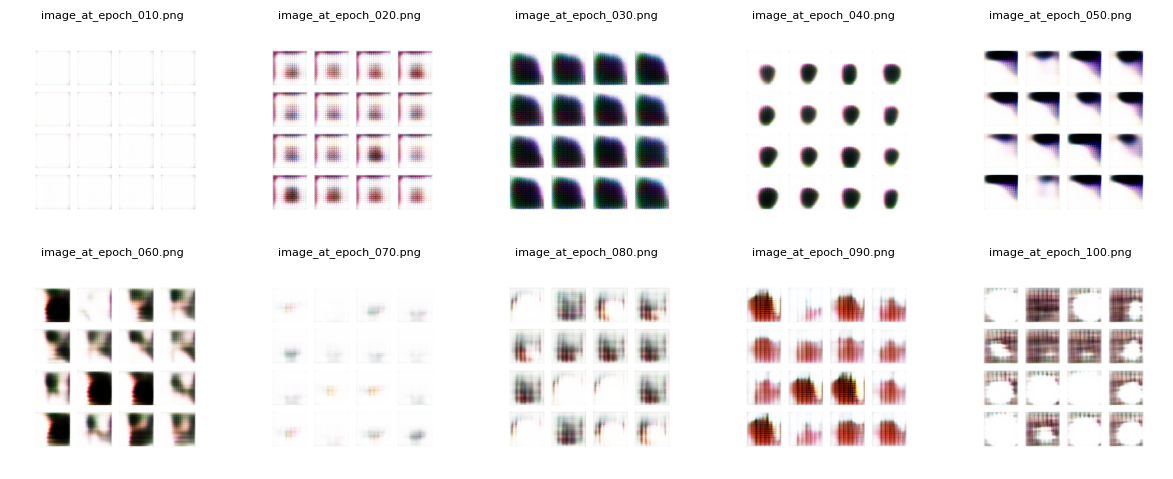

## GIF

In [ ]:
import imageio
import glob
import os

anim_file = 'dcgan_model_2_gif.gif'
dir = '/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1_v3'


with imageio.get_writer(anim_file, mode='I') as writer:
  # filenames = glob.glob('image*.png')
  filenames = glob.glob(os.path.join(dir, 'image*.png'))
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

/tmp/ipython-input-2-665368621.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
